<a href="https://colab.research.google.com/github/s-kp/CapstoneProject-FaceEmotionRecognition/blob/main/FER_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Table of Contents**

- [1 - Project Introduction](#1)
- [2 - Importing Dependencies](#2)
- [3 - Defining Prerequisites](#2)
- [4 - Modified LeNet](#2)
- [5 - AlexNet](#2)
- [6 - MobileNetV2](#2)
- [7 - VGG16](#2)
- [6 - VGG19](#2)
- [9 - Custom Model](#2)
- [10 - Basic Inception](#2)



<a name='1'></a>
# **Project Introduction**


The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (ex- Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

## **Problem Statements**

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data. The solution to this problem is by recognizing facial emotions.

**Face Emotion Recognition:**
This is a few shot learning live face emotion detection system. The model should be able to real-time identify the emotions of students in a live class.

<a name='2'></a>
# **Importing Dependencies**

In [ ]:
# Importing libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os 
tf.random.set_seed(42)

In [ ]:
# Downloading the dataset
!gdown --id 1kdAI0wrR_bTBs-6pbKB6giz-JcNaTY-s

# Unzipping the files
!unzip '/content/dataset.zip'

In [ ]:
# Defining te path of train and test dataset
train_dir = '/content/train'
test_dir = '/content/test'

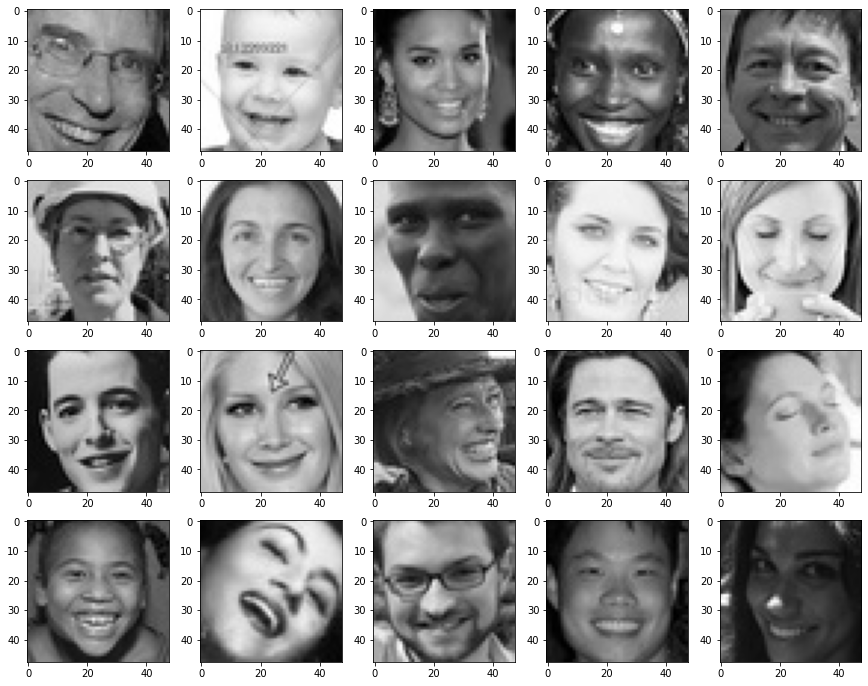

In [ ]:
# Displaying sample Images
path = '/content/train/happy/'
plt.figure(figsize=(15,12))
for i in range(1, 21):
    plt.subplot(4,5,i)
    img = load_img(path + os.listdir(path)[i])
    plt.imshow(img)   
plt.show()

In [ ]:
# Generating batches of tensor image data with real-time data augmentation.
batch = 64
img = (48,48)
color = "grayscale"
valid_gen = ImageDataGenerator(rescale=1./255)
train_gen = ImageDataGenerator(rotation_range=20, rescale=1./255, shear_range=0.1, zoom_range=0.2, horizontal_flip=True,
                              width_shift_range=0.1, height_shift_range=0.1)

train_data = train_gen.flow_from_directory(train_dir, target_size=img, batch_size=batch, color_mode=color, class_mode="categorical")
validation = valid_gen.flow_from_directory(test_dir, target_size=img, batch_size=batch, color_mode=color, class_mode="categorical")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


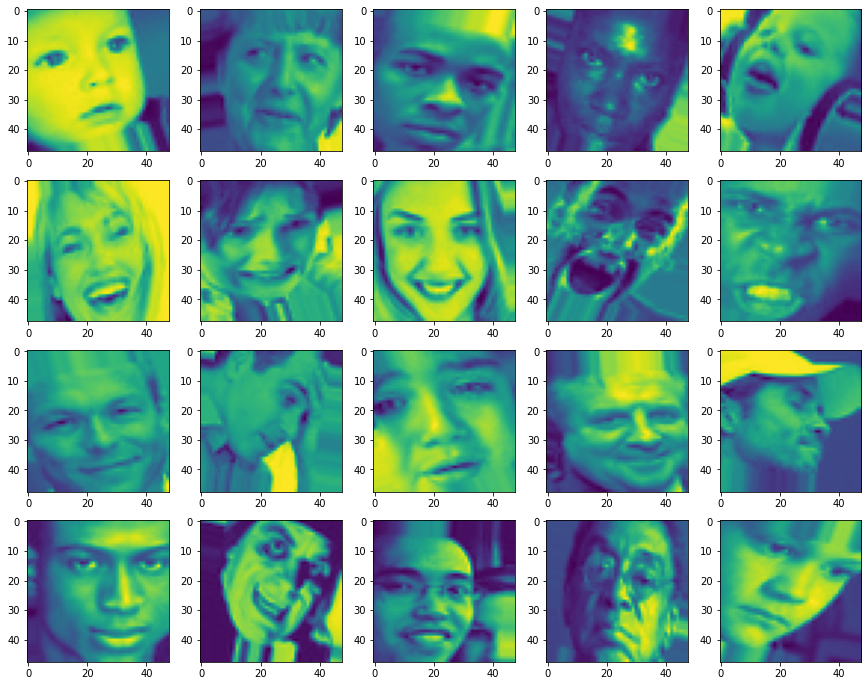

In [ ]:
# Displaying sample images from the training set after augmentation
random_image = np.random.choice(64, size=20, replace=False)
random_batch = np.random.choice(112,size=20, replace=False)
fig,axes=plt.subplots(4,5,figsize=(15,12))
for id, ax in enumerate(axes.flatten()):
  pic = train_data[random_batch[id]][0][random_image[id]]
  ax.imshow(pic.reshape(48,-1))

In [ ]:
# checking te shape of image and the label
image_batch, label_batch = next(iter(train_data))
print('image shape',image_batch[0].shape)
print('Label shape',label_batch[0].shape)

image shape (48, 48, 1)
Label shape (7,)


<a name='2'></a>
# **Defining prerequisites**

In [ ]:
# Defining te default optimizer for compiling te models
opt = Adam(learning_rate=0.0001, decay=1e-6)

In [ ]:
# Defining a function to generate callbacks
def callback_list(name, esp=9, lrp=3):
    ''' Defining a function to generate the list of callbacks
    Arguments:
        name -- name of the model
        esp -- early stopping patience
        lrp -- reduce learning rate patience
    Returns:
        the list of callbacks
    '''
    # Callback to save the Keras model or model weights at some frequency.
    checkpoint = ModelCheckpoint(f"{name}.h5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    # Stop training when a monitored metric has stopped improving.
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=esp, verbose=1, restore_best_weights=True)
    # Reduce learning rate when a metric has stopped improving.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=lrp, verbose=1, min_delta=0.0001)
    # Defining a list of all the callbacks
    callbacks = [earlystop, checkpoint, reduce_lr]

    return callbacks

In [ ]:
# Plot the training and validation accuracy and loss
def plots(history):
    ''' Defining a function to Plot the accuracy and loss
    Arguments:
        name -- name of the model
        esp -- early stopping patience
        lrp -- reduce learning rate patience
    Returns:
        the list of callbacks
    '''
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

<a name='2'></a>
# **Modified LeNet**

In [ ]:
# Defining a CNN architecture using keras sequential API
lenet = Sequential([# First CNN layer
                    Conv2D(filters=6, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)),
                    BatchNormalization(), MaxPool2D(pool_size = 2),
                    # Second CNN layer
                    Conv2D(filters=16, kernel_size=3, activation='relu',  padding='same'),
                    BatchNormalization(), MaxPool2D(pool_size = 2),
                    # flattening and Adding 2 fully connected layers
                    Flatten(),
                    Dense(120, activation='relu'),
                    Dense(84, activation='relu'),
                    # using a prediction layer with seven neuron 
                    Dense(7, activation='softmax')])

# Compiling the model
lenet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# checking summary
lenet.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 48, 48, 6)         60        
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 6)        24        
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 24, 24, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 24, 24, 16)        880       
                                                                 
 batch_normalization_13 (Bat  (None, 24, 24, 16)       64        
 chNormalization)                                                
                                                      

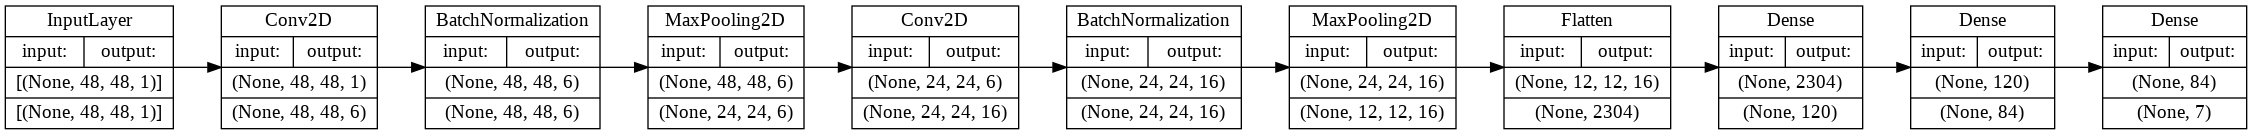

In [ ]:
# Plot model graph
plot_model(lenet, show_shapes=True, to_file='lenet.png', rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
history = lenet.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('lenet'))

Epoch 1/100
448/449 [============================>.] - ETA: 0s - loss: 1.7988 - accuracy: 0.2719
Epoch 1: val_loss improved from inf to 1.69618, saving model to lenet.h5
449/449 [==============================] - 26s 56ms/step - loss: 1.7988 - accuracy: 0.2720 - val_loss: 1.6962 - val_accuracy: 0.3277 - lr: 1.0000e-04
Epoch 2/100
448/449 [============================>.] - ETA: 0s - loss: 1.7119 - accuracy: 0.3152
Epoch 2: val_loss improved from 1.69618 to 1.64431, saving model to lenet.h5
449/449 [==============================] - 24s 54ms/step - loss: 1.7116 - accuracy: 0.3155 - val_loss: 1.6443 - val_accuracy: 0.3559 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.6903 - accuracy: 0.3279
Epoch 3: val_loss improved from 1.64431 to 1.61937, saving model to lenet.h5
449/449 [==============================] - 24s 54ms/step - loss: 1.6903 - accuracy: 0.3279 - val_loss: 1.6194 - val_accuracy: 0.3686 - lr: 1.0000e-04
Epoch 4/100
448/449 [===========

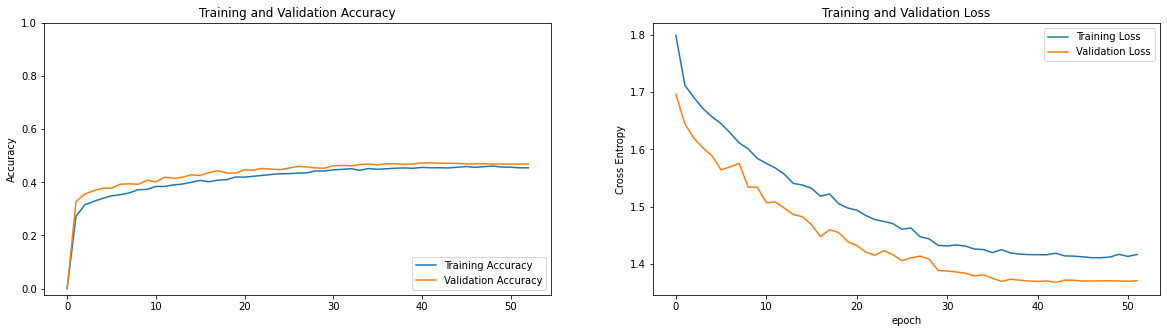

In [ ]:
plots(history)

<a name='2'></a>
# **Alexnet**

In [ ]:
# AlexNet CNN architecture from scratch using keras sequential API
alexnet = Sequential([# The first block with 1 conv
                      Conv2D(96, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)),
                      BatchNormalization(), MaxPool2D(pool_size=(2,2)),
                      # The second block with 1 conv
                      Conv2D(256, kernel_size=3, activation='relu', padding='same'),
                      BatchNormalization(), MaxPool2D(pool_size=(2,2)),
                      # The third block with 3 conv
                      Conv2D(384, kernel_size=3, activation='relu', padding='same'),
                      Conv2D(384, kernel_size=3, activation='relu', padding='same'),
                      Conv2D(256, kernel_size=3, activation='relu', padding='same'),
                      MaxPool2D(pool_size=(2,2)),
                      # Flattening and Using 2 fully connected layer with 4096 units and relu activation
                      Flatten(),
                      Dense(4096, activation='relu'), Dropout(0.5),
                      Dense(4096, activation='relu'), Dropout(0.5),
                      # Using a prediction layer with seven neuron
                      Dense(7, activation='softmax')])

# Compiling the model
alexnet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# checking summary
alexnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 48, 48, 96)        960       
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 96)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 256)       221440    
                                                                 
 batch_normalization_3 (Batc  (None, 24, 24, 256)      1024      
 hNormalization)                                                 
                                                      

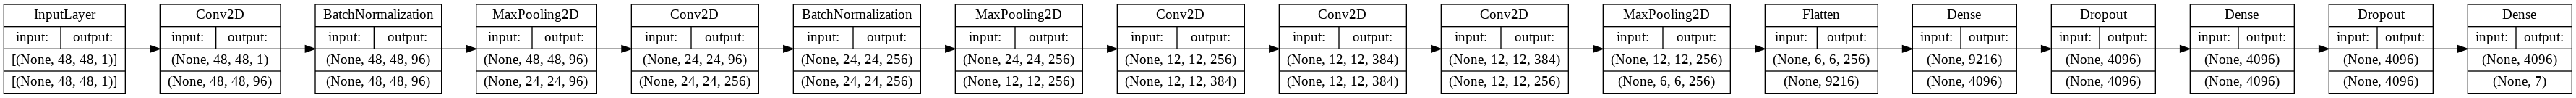

In [ ]:
# Plot model graph
plot_model(alexnet, to_file='alexnet.png', show_shapes=True, rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
history = alexnet.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('alexnet'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.6934
Epoch 1: val_loss improved from inf to 0.95822, saving model to alexnet.h5
449/449 [==============================] - 31s 68ms/step - loss: 0.8152 - accuracy: 0.6934 - val_loss: 0.9582 - val_accuracy: 0.6513 - lr: 1.6000e-07
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.6937
Epoch 2: val_loss did not improve from 0.95822
449/449 [==============================] - 29s 64ms/step - loss: 0.8152 - accuracy: 0.6937 - val_loss: 0.9599 - val_accuracy: 0.6514 - lr: 1.6000e-07
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 0.8158 - accuracy: 0.6958
Epoch 3: val_loss did not improve from 0.95822
449/449 [==============================] - 29s 63ms/step - loss: 0.8158 - accuracy: 0.6958 - val_loss: 0.9598 - val_accuracy: 0.6520 - lr: 1.6000e-07
Epoch 4/100
449/449 [==============================] - ETA: 0s - loss: 0.8069 - accuracy: 

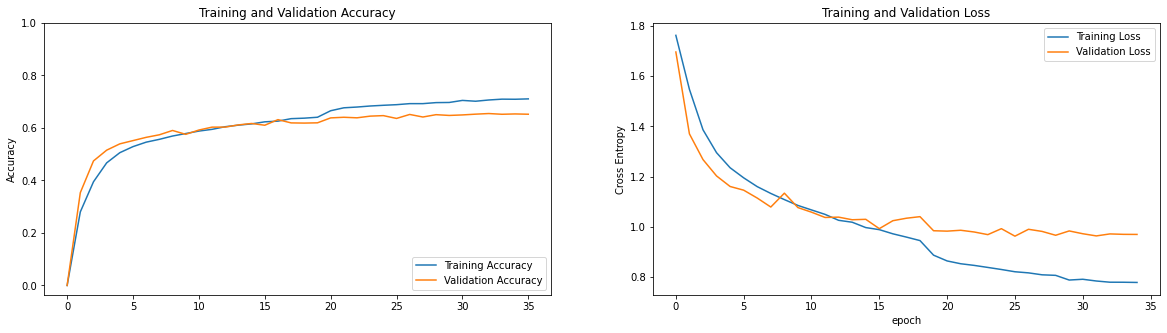

In [ ]:
# Plotting te accuracy and loss
plots(history)

<a name='2'></a>
# **Mobilenet**

In [ ]:
# categorical classification using MobileNetV2 
mobilenet = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for mobilenet
                        Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                        # Using MobileNetV2
                        MobileNetV2(weights='imagenet', include_top=False, pooling = 'avg'),
                        # Using a fully connected layer with 128 units and relu activation
                        Dense(128, activation='relu'),
                        # Using a fully connected layer with 64 units and relu activation
                        Dense(64, activation='relu'),
                        # Using a prediction layer with seven neuron
                        Dense(7, activation='softmax')])

# Compiling the model
mobilenet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# checking summary
mobilenet.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 3)         30        
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_11 (Dense)            (None, 128)               163968    
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 7)                 455       
                                                                 
Total params: 2,430,693
Trainable params: 2,396,581
Non-t

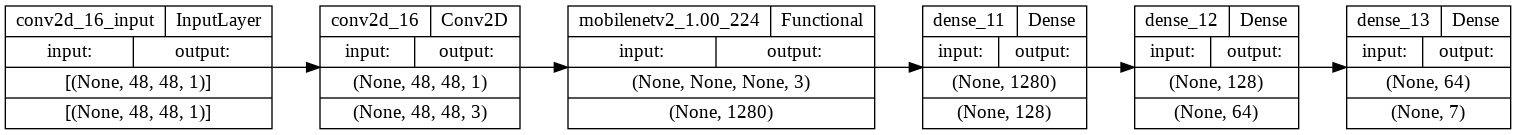

In [ ]:
# Plot model graph
plot_model(mobilenet, show_shapes=True, to_file='mobilenet.png', rankdir='LR')

In [ ]:
# Fitting the model
history = mobilenet.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('mobilenet'))

Epoch 1/100
448/449 [============================>.] - ETA: 0s - loss: 1.8550 - accuracy: 0.2429
Epoch 1: val_loss improved from inf to 1.87348, saving model to mobilenet.h5
449/449 [==============================] - 46s 68ms/step - loss: 1.8547 - accuracy: 0.2432 - val_loss: 1.8735 - val_accuracy: 0.2442 - lr: 1.0000e-04
Epoch 2/100
448/449 [============================>.] - ETA: 0s - loss: 1.7203 - accuracy: 0.3128
Epoch 2: val_loss improved from 1.87348 to 1.81766, saving model to mobilenet.h5
449/449 [==============================] - 29s 65ms/step - loss: 1.7205 - accuracy: 0.3128 - val_loss: 1.8177 - val_accuracy: 0.2531 - lr: 1.0000e-04
Epoch 3/100
448/449 [============================>.] - ETA: 0s - loss: 1.6599 - accuracy: 0.3426
Epoch 3: val_loss improved from 1.81766 to 1.80717, saving model to mobilenet.h5
449/449 [==============================] - 28s 62ms/step - loss: 1.6598 - accuracy: 0.3426 - val_loss: 1.8072 - val_accuracy: 0.2724 - lr: 1.0000e-04
Epoch 4/100
448/449 

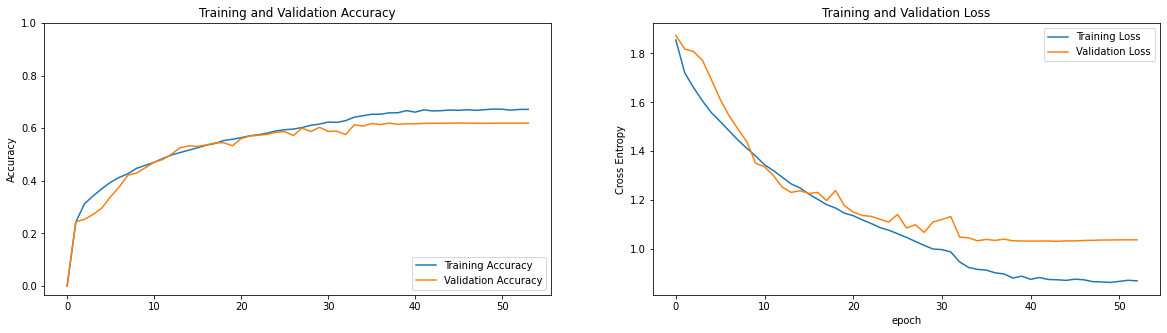

In [ ]:
# Plotting te accuracy and loss
plots(history)

<a name='2'></a>
# **VGG16**

In [ ]:
# categorical classification using VGG16 
vgg16 = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for vgg16
                    Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                    # Using VGG16 and Flattening the output
                    VGG16(include_top=False), Flatten(), BatchNormalization(),
                    # Using 2 fully connected layer with 4096 units and relu activation
                    Dense(4096, activation='relu'), BatchNormalization(),
                    Dense(4096, activation='relu'), BatchNormalization(),
                    # Using a prediction layer with seven neuron
                    Dense(7, activation='softmax')])

# Compiling the model
vgg16.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# checking summary
vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 48, 48, 3)         30        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_12 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 4096)              2101248   
                                                                 
 batch_normalization_13 (Bat  (None, 4096)             

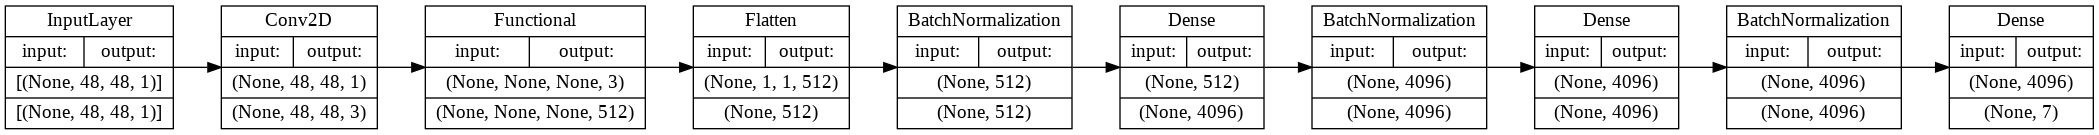

In [ ]:
# Plot model graph
plot_model(vgg16, show_shapes=True, to_file='vgg16.png', rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
history = vgg16.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('vgg16'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.8755 - accuracy: 0.3089
Epoch 1: val_loss improved from inf to 9.15998, saving model to vgg16.h5
449/449 [==============================] - 37s 80ms/step - loss: 1.8755 - accuracy: 0.3089 - val_loss: 9.1600 - val_accuracy: 0.1160 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.5078 - accuracy: 0.4279
Epoch 2: val_loss improved from 9.15998 to 2.85609, saving model to vgg16.h5
449/449 [==============================] - 36s 80ms/step - loss: 1.5078 - accuracy: 0.4279 - val_loss: 2.8561 - val_accuracy: 0.2144 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.3820 - accuracy: 0.4778
Epoch 3: val_loss improved from 2.85609 to 2.48691, saving model to vgg16.h5
449/449 [==============================] - 35s 77ms/step - loss: 1.3820 - accuracy: 0.4778 - val_loss: 2.4869 - val_accuracy: 0.3194 - lr: 1.0000e-04
Epoch 4/100
449/449 [===========

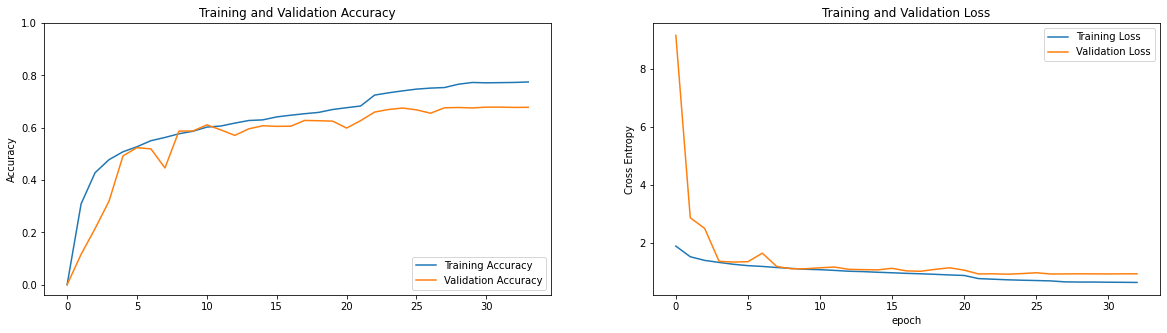

In [ ]:
# Plotting te accuracy and loss
plots(history)

<a name='2'></a>
# **VGG19**

In [ ]:
# categorical classification using VGG19 
vgg19 = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for vgg19
                    Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                    # Using VGG19 and Flattening the output
                    VGG19(include_top=False), Flatten(), BatchNormalization(),
                    # Using 2 fully connected layer with 4096 units and relu activation
                    Dense(4096, activation='relu'), BatchNormalization(),
                    Dense(4096, activation='relu'), BatchNormalization(),
                    # Using a prediction layer with seven neuron
                    Dense(7, activation='softmax')])

# Compiling the model
vgg19.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# checking summary
vgg19.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 48, 48, 3)         30        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_15 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 4096)              2101248   
                                                                 
 batch_normalization_16 (Bat  (None, 4096)             

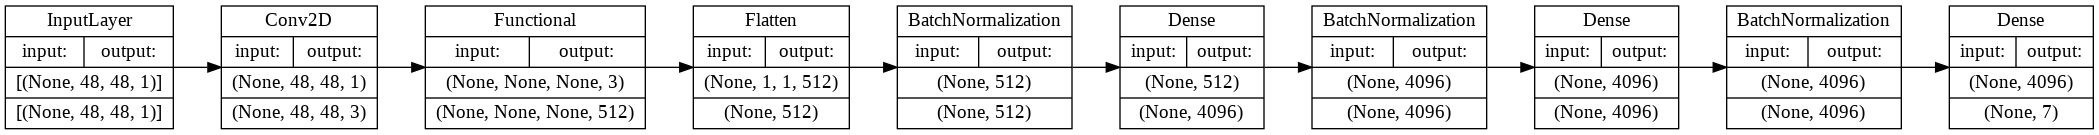

In [ ]:
# Plot model graph
plot_model(vgg19, show_shapes=True, to_file='vgg19.png', rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
history = vgg19.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('vgg19'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.9825 - accuracy: 0.2395
Epoch 1: val_loss improved from inf to 2.82886, saving model to vgg19.h5
449/449 [==============================] - 43s 93ms/step - loss: 1.9825 - accuracy: 0.2395 - val_loss: 2.8289 - val_accuracy: 0.2685 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.5947 - accuracy: 0.3808
Epoch 2: val_loss did not improve from 2.82886
449/449 [==============================] - 41s 90ms/step - loss: 1.5947 - accuracy: 0.3808 - val_loss: 3.2508 - val_accuracy: 0.3945 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.4519 - accuracy: 0.4463
Epoch 3: val_loss improved from 2.82886 to 1.34743, saving model to vgg19.h5
449/449 [==============================] - 42s 93ms/step - loss: 1.4519 - accuracy: 0.4463 - val_loss: 1.3474 - val_accuracy: 0.4882 - lr: 1.0000e-04
Epoch 4/100
449/449 [==============================] - ETA: 0s

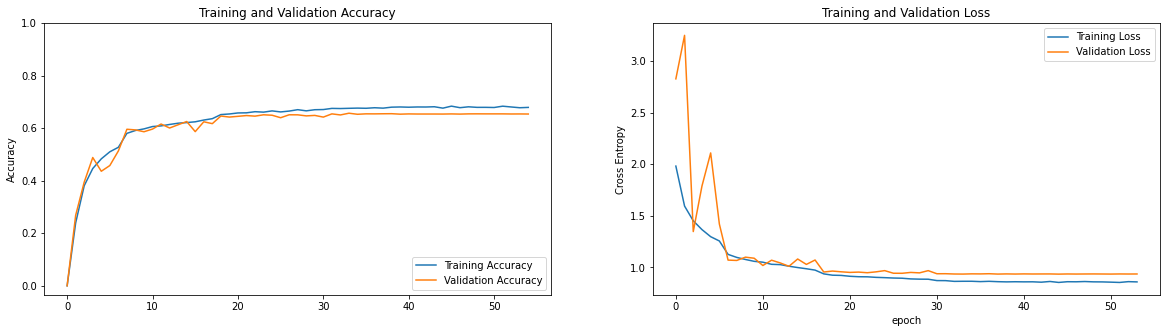

In [ ]:
# Plotting te accuracy and loss
plots(history)

<a name='2'></a>
# **Custom Model**

In [ ]:
# Defining a CNN architecture using keras sequential API
custom_model = Sequential([# First CNN layer
                           Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=(48, 48, 1)),
                           # Second CNN layer
                           Conv2D(filters=64, kernel_size=5, activation='relu'),
                           MaxPool2D(pool_size = 2),
                           # Third CNN layer and flattening te outputs
                           Conv2D(filters=128, kernel_size=3, activation='relu'),
                           MaxPool2D(pool_size = 2), Flatten(),
                           # Adding 2 fully connected layers with dropout
                           Dense(1024, activation='relu'), Dropout(0.5),
                           Dense(512, activation='relu'), Dropout(0.5),
                           # using a prediction layer with seven neuron 
                           Dense(7, activation='softmax')])

# Compiling the model
custom_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# checking summary
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 44, 44, 32)        832       
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 64)        51264     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 18, 18, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 9, 128)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 10368)            

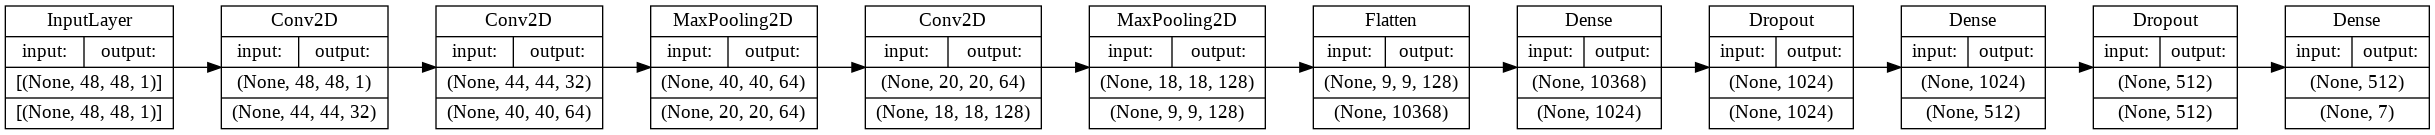

In [ ]:
# Plot model graph
plot_model(custom_model, show_shapes=True, to_file='custom_model.png', rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
history = custom_model.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('custom_model'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.8130 - accuracy: 0.2515
Epoch 1: val_loss improved from inf to 1.70404, saving model to custom_model.h5
449/449 [==============================] - 25s 54ms/step - loss: 1.8130 - accuracy: 0.2515 - val_loss: 1.7040 - val_accuracy: 0.3220 - lr: 1.0000e-04
Epoch 2/100
448/449 [============================>.] - ETA: 0s - loss: 1.7312 - accuracy: 0.3016
Epoch 2: val_loss improved from 1.70404 to 1.59658, saving model to custom_model.h5
449/449 [==============================] - 24s 53ms/step - loss: 1.7311 - accuracy: 0.3018 - val_loss: 1.5966 - val_accuracy: 0.3780 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.6701 - accuracy: 0.3378
Epoch 3: val_loss improved from 1.59658 to 1.51084, saving model to custom_model.h5
449/449 [==============================] - 24s 54ms/step - loss: 1.6701 - accuracy: 0.3378 - val_loss: 1.5108 - val_accuracy: 0.4138 - lr: 1.0000e-04
Epoch 4/100

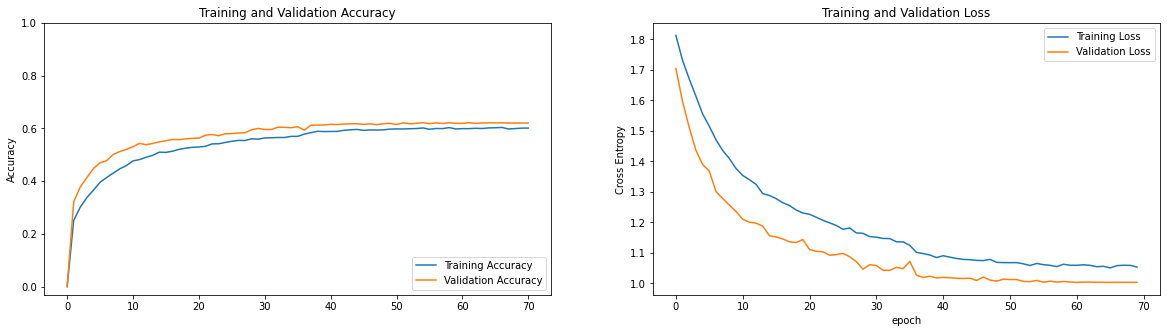

In [ ]:
plots(history)

<a name='2'></a>
# **Basic Inception Model**

In [ ]:
# Defining a function for basic inception model
def basic_inception(input_shape=(48,48,1), F1=32, F3_in=32, F3_out=64, F5_in=8, F5_out=16, Mp_out=16):
    ''' Defining a basic inception model for categorical classification out of the two inception blocks
    Arguments:
        input_shape -- Image width,height and channels
        F1 -- Number of 1x1 filters
        F3_in -- Number of 1x1 filters to place before the 3x3 filter
        F3_out -- Number of 3x3 filters
        F5_in -- Number of 1x1 filters to place before the 5x5 filter
        F5_out -- Number of 5x5 filters
        Mp_out -- Number of 1x1 filters to place after maxpooling
    Returns:
        basic inception model with 3 inception blocks, 2 FC layers and one prediction layer wit 7 neurons.
    '''
    # Define input
    inputs = Input(shape=input_shape)

    # Creating a basic inception block
    def inception_block(input_layer, f1=F1, f3_in=F3_in, f3_out=F3_out, f5_in=F5_in, f5_out=F5_out, mp_out=Mp_out):
        # 1x1 Convolution
        conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(input_layer)
        # 3x3 Convolution
        conv3 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(input_layer)
        conv3 = Conv2D(f3_out, (3,3), padding='same', activation='relu')(conv3)
        # 5x5 Convolution
        conv5 = Conv2D(f5_in, (1,1), padding='same', activation='relu')(input_layer)
        conv5 = Conv2D(f5_out, (5,5), padding='same', activation='relu')(conv5)
        # 3x3 Max Pooling
        pool = MaxPool2D((3,3), strides=(1,1), padding='same')(input_layer)
        pool = Conv2D(mp_out, (1,1), padding='same', activation='relu')(pool)
        # Concatenate
        layer_out = Concatenate(axis=-1)([conv1, conv3, conv5, pool])
        return layer_out

    # First inception block
    iblock1 = inception_block(inputs)
    iblock1 = BatchNormalization()(iblock1)
    # Second inception block
    iblock2 = inception_block(iblock1)
    iblock2 = BatchNormalization()(iblock2)
    # Third inception block
    iblock3 = inception_block(iblock2)
    
    # Flattening for output
    flat = Flatten()(iblock3)
    flat = BatchNormalization()(flat)
    
    # Adding 2 FC layers and the prediction layer
    dense1 = Dense(256, activation='relu')(flat)
    dense1 = BatchNormalization()(dense1)
    dense2 = Dense(128, activation='relu')(dense1)
    dense2 = BatchNormalization()(dense2)
    outputs = Dense(7, activation='softmax')(dense2)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
# Defining the model
inception = basic_inception()

# Compiling the model
inception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# checking summary
inception.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_69 (Conv2D)             (None, 48, 48, 32)   64          ['input_4[0][0]']                
                                                                                                  
 conv2d_71 (Conv2D)             (None, 48, 48, 8)    16          ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_23 (MaxPooling2D  (None, 48, 48, 1)   0           ['input_4[0][0]']                
 )                                                                                          

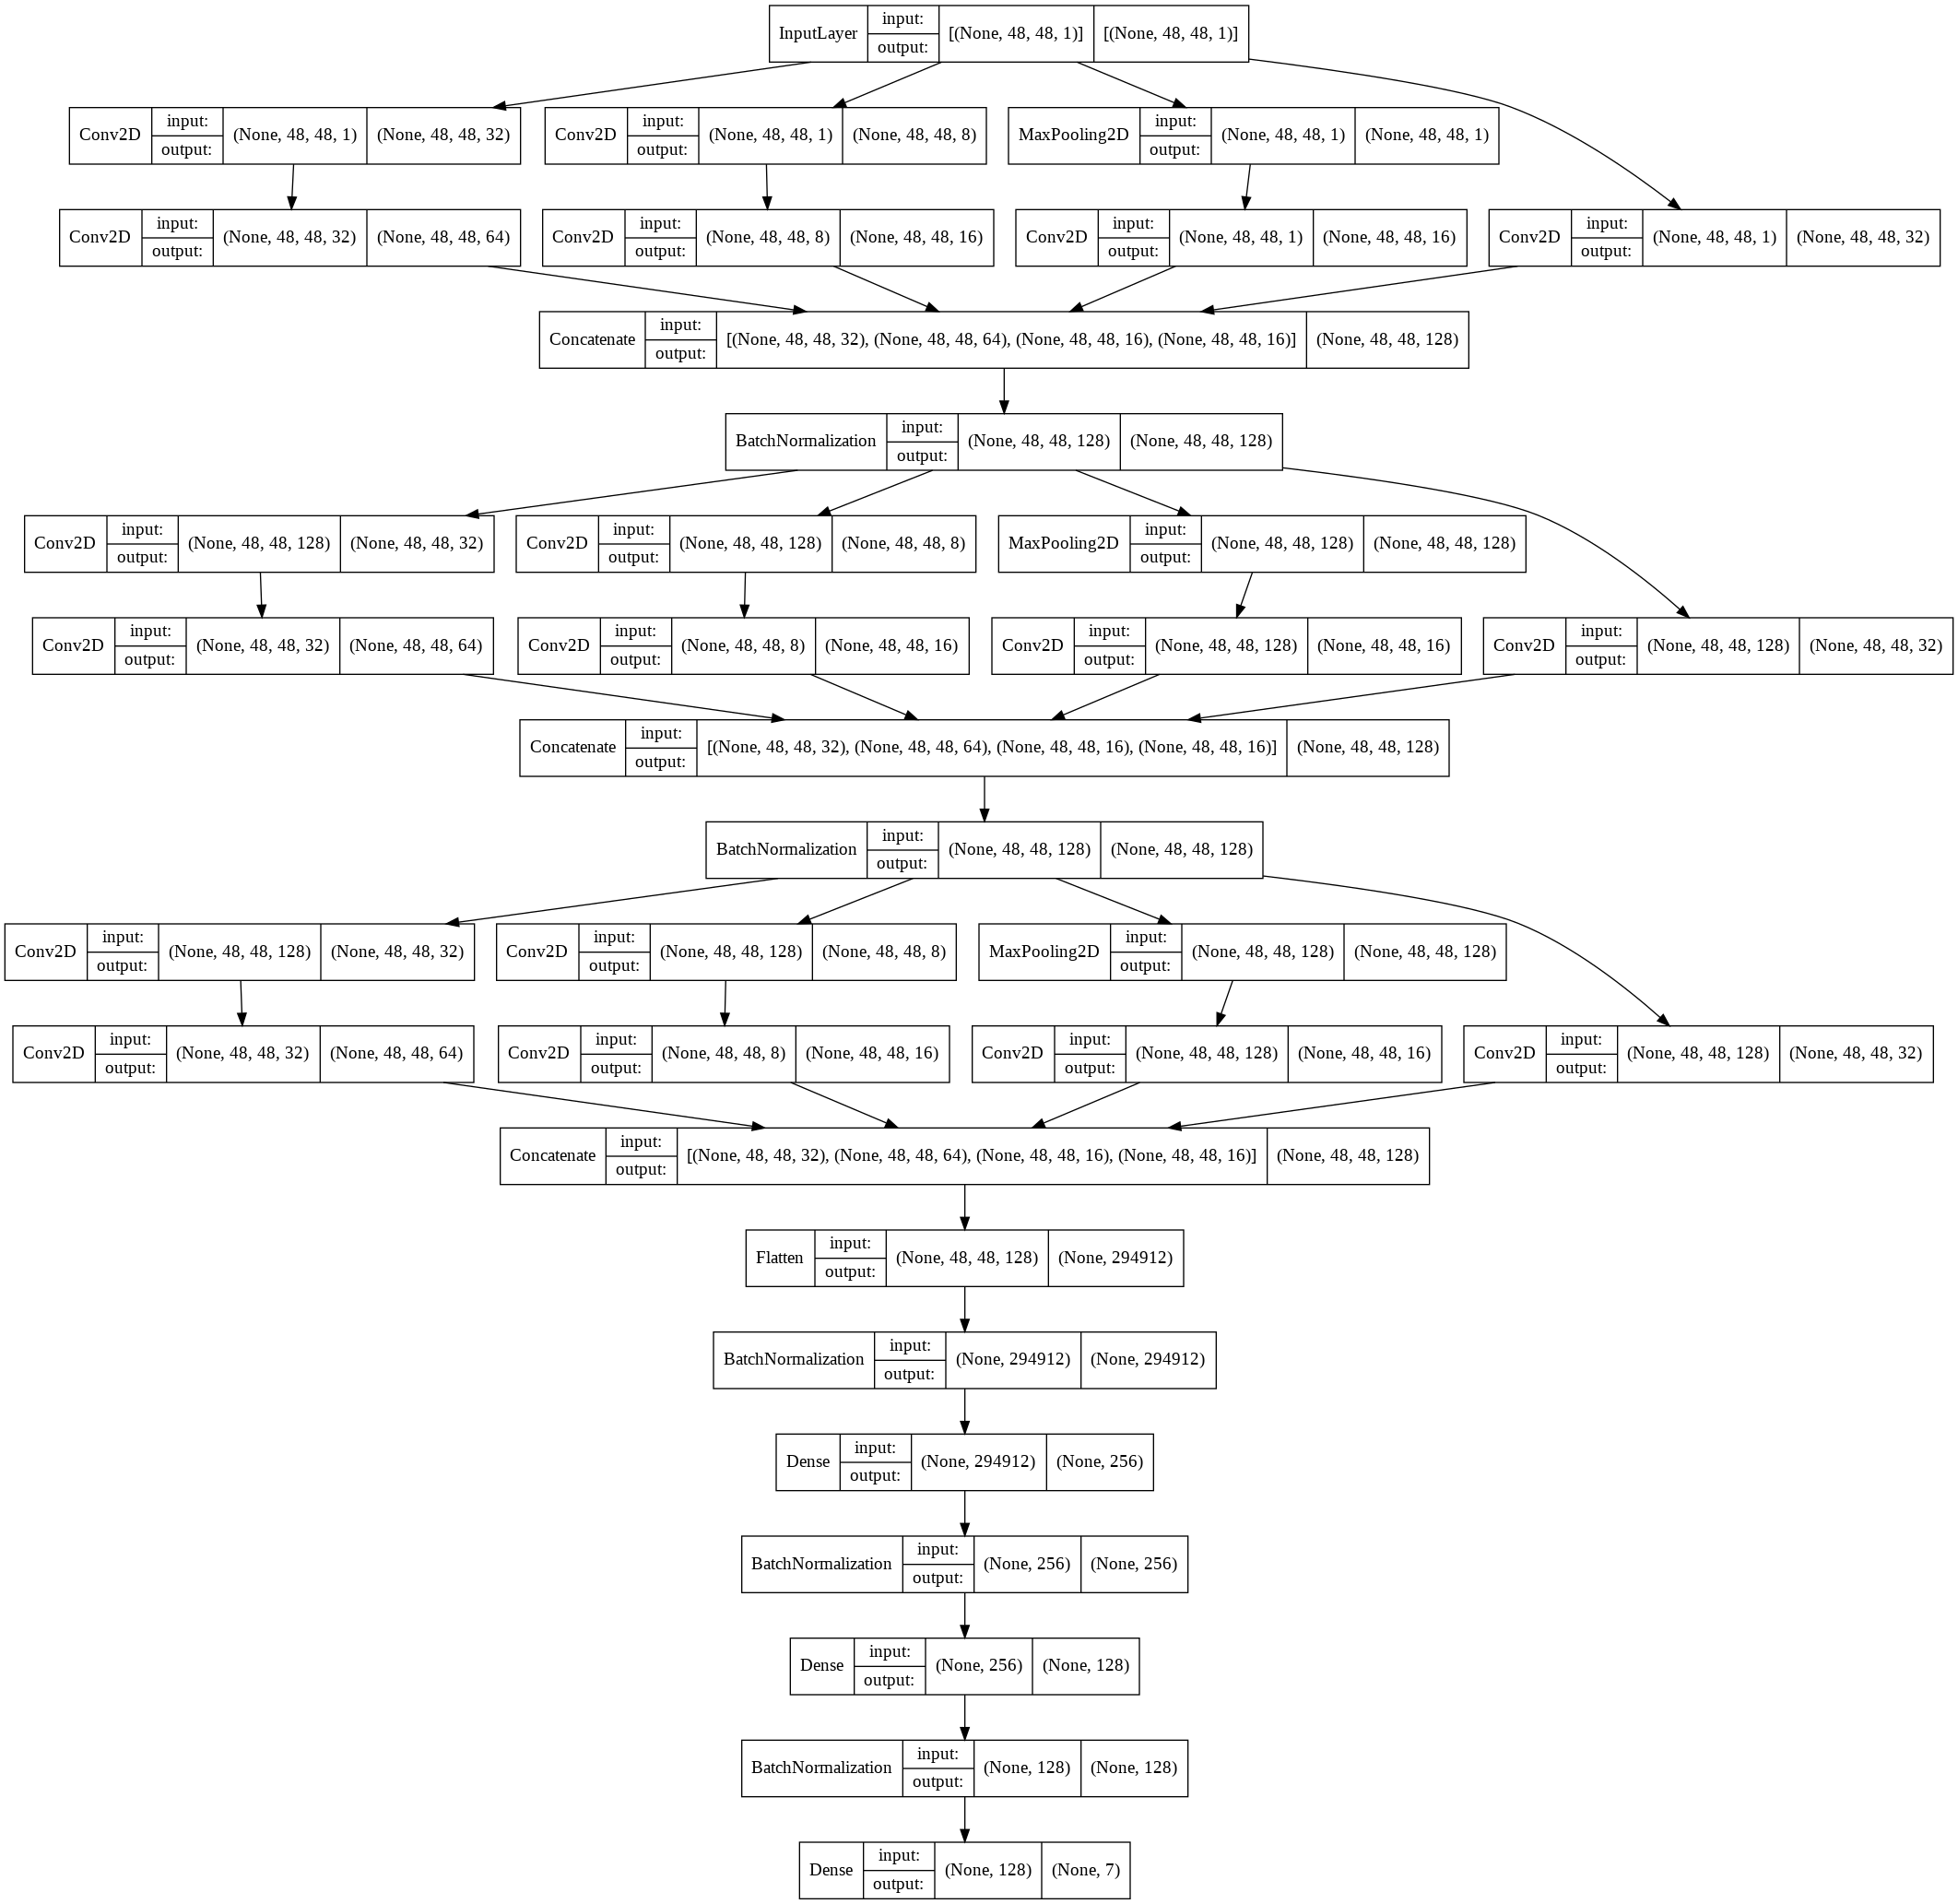

In [ ]:
# Plot model graph
plot_model(inception, show_shapes=True, to_file='inception.png', show_layer_names=False)

In [ ]:
# Fitting the model
history = inception.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('inception'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.8469 - accuracy: 0.2942
Epoch 1: val_loss improved from inf to 1.83303, saving model to inception.h5
449/449 [==============================] - 57s 123ms/step - loss: 1.8469 - accuracy: 0.2942 - val_loss: 1.8330 - val_accuracy: 0.2972 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.6451 - accuracy: 0.3741
Epoch 2: val_loss improved from 1.83303 to 1.52922, saving model to inception.h5
449/449 [==============================] - 54s 120ms/step - loss: 1.6451 - accuracy: 0.3741 - val_loss: 1.5292 - val_accuracy: 0.4256 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.5519 - accuracy: 0.4050
Epoch 3: val_loss improved from 1.52922 to 1.45382, saving model to inception.h5
449/449 [==============================] - 54s 120ms/step - loss: 1.5519 - accuracy: 0.4050 - val_loss: 1.4538 - val_accuracy: 0.4446 - lr: 1.0000e-04
Epoch 4/100
449/4

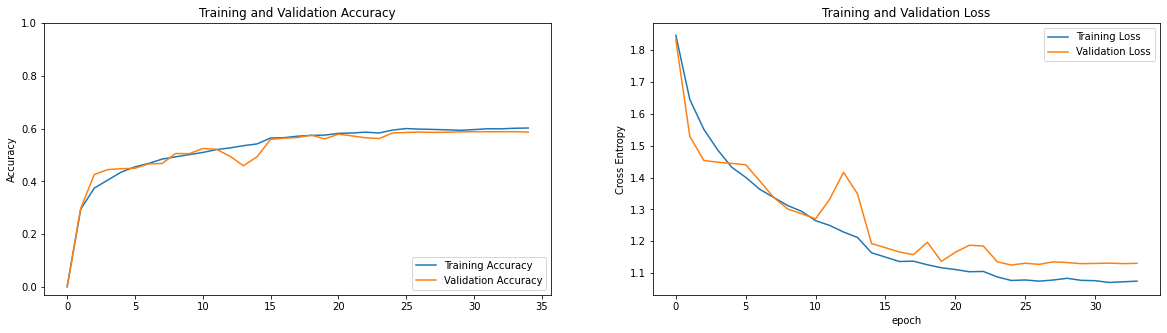

In [ ]:
plots(history)